# Figure 7:  SMYLE & DPLE seasonal NAO skill

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import matplotlib.pyplot as plt
%matplotlib inline

# import plotting and other utilities from SMYLEutils
from SMYLEutils import calendar_utils as cal
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import eof_utils as eof

# import ESP-Lab modules
from esp_lab import data_access
from esp_lab import stats

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2021.09.0'

## Preprocessing:  Data I/O using Dask

### Create Dask Cluster

In [33]:
cluster.close()
client.close()

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(30) 

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35713 instead
  warnings.warn(


In [4]:
cluster

### Read in CAM monthly data; Convert to Seasonal averages (DJF, MAM, JJA, SON)
- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead season). For example, for November starts, L=1 corresponds to first DJF season.
- "time" which gives prediction verification time (centered time for a given season) is also dimensioned with (Y,L)

In [5]:
# This preprocessor will return a monthly mean field
def preprocessor(ds0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for a your analysis to speed up processing. 
    """
    ds0 = cal.time_set_midmonth(ds0,'time')
    d0 = ds0[field].isel(time=slice(0, nlead))
    d0 = d0.assign_coords({"lon":ds0.lon, "lat":ds0.lat})
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.to_dataset(name=field)
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    return d0

In [6]:
%%time
# SMYLE-NOV PSL data
# process all 20 ensemble members, all start dates from 1970-2019:
field = 'PSL'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
inityears = np.arange(1970,2020,1)
startmonth = 11
chunk = {}
smyle11 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle11.nbytes/1e9 #GB

CPU times: user 40.2 s, sys: 17.7 s, total: 57.9 s
Wall time: 1min 49s


5.308430192

In [7]:
%%time
smyle11_seas = cal.mon_to_seas_dask(smyle11).persist()
daskout = wait(smyle11_seas)

CPU times: user 41.4 s, sys: 984 ms, total: 42.4 s
Wall time: 44.9 s


In [8]:
%%time
# SMYLE-FEB PSL data
# process all 20 ensemble members, all start dates from 1970-2019:
field = 'PSL'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
inityears = np.arange(1970,2020,1)
startmonth = 2
chunk = {}
smyle02 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle02.nbytes/1e9 #GB

CPU times: user 45.3 s, sys: 19 s, total: 1min 4s
Wall time: 1min 43s


5.308430192

In [9]:
%%time
smyle02_seas = cal.mon_to_seas_dask(smyle02).persist()
daskout = wait(smyle02_seas)

CPU times: user 44.4 s, sys: 877 ms, total: 45.2 s
Wall time: 47.2 s


In [10]:
%%time
# SMYLE-MAY PSL data
# process all 20 ensemble members, all start dates from 1970-2019:
field = 'PSL'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
inityears = np.arange(1970,2020,1)
startmonth = 5
chunk = {}
smyle05 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle05.nbytes/1e9 #GB

CPU times: user 48.6 s, sys: 18.6 s, total: 1min 7s
Wall time: 1min 48s


5.308430192

In [11]:
%%time
smyle05_seas = cal.mon_to_seas_dask(smyle05).persist()
daskout = wait(smyle05_seas)

CPU times: user 46.3 s, sys: 791 ms, total: 47.1 s
Wall time: 49.8 s


In [12]:
%%time
# SMYLE-AUG PSL data
# process all 20 ensemble members, all start dates from 1970-2019:
field = 'PSL'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
inityears = np.arange(1970,2020,1)
startmonth = 8
chunk = {}
smyle08 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle08.nbytes/1e9 #GB

CPU times: user 47.7 s, sys: 18.6 s, total: 1min 6s
Wall time: 1min 42s


5.308430192

In [13]:
%%time
smyle08_seas = cal.mon_to_seas_dask(smyle08).persist()
daskout = wait(smyle08_seas)

CPU times: user 48.2 s, sys: 1.01 s, total: 49.2 s
Wall time: 51.9 s


In [14]:
%%time
# DPLE-NOV PSL data
# process all 40 ensemble members, all start dates from 1970-2017:
field = 'PSL'
datadir = '/glade/campaign/cesm/collections/CESM1-DPLE/atm/proc/tseries/monthly/'
casename = 'b.e11.BDP.f09_g16.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+field+'/'+casename+filetype+field+'.*.nc'
ens = 40 
nlead = 24
inityears = np.arange(1970,2018,1)
startmonth = 11
chunk = {}
dple11 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
dple11.nbytes/1e9 #GB

CPU times: user 14.6 s, sys: 2.34 s, total: 17 s
Wall time: 20 s


10.192172672

In [15]:
%%time
dple11_seas = cal.mon_to_seas_dask(dple11).persist()
daskout = wait(dple11_seas)

CPU times: user 1min 33s, sys: 2.03 s, total: 1min 35s
Wall time: 1min 43s


### Store datasets to disk for quicker processing next time (note this takes >30 minutes)

In [16]:
%%time
## Save Fig data to file:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
dple11_seas.to_netcdf(outdir+'DPLE11_PSL_seas.nc')
smyle11_seas.to_netcdf(outdir+'SMYLE11_PSL_seas.nc')
smyle02_seas.to_netcdf(outdir+'SMYLE02_PSL_seas.nc')
smyle05_seas.to_netcdf(outdir+'SMYLE05_PSL_seas.nc')
smyle08_seas.to_netcdf(outdir+'SMYLE08_PSL_seas.nc')

CPU times: user 14min 30s, sys: 19.6 s, total: 14min 50s
Wall time: 34min 41s


In [5]:
## Retrieve pre-saved Fig data:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
dple11_seas = xr.open_dataset(outdir+'DPLE11_PSL_seas.nc').isel(L=slice(0,7))
smyle11_seas = xr.open_dataset(outdir+'SMYLE11_PSL_seas.nc').isel(L=slice(0,7))
smyle02_seas = xr.open_dataset(outdir+'SMYLE02_PSL_seas.nc').isel(L=slice(0,7))
smyle05_seas = xr.open_dataset(outdir+'SMYLE05_PSL_seas.nc').isel(L=slice(0,7))
smyle08_seas = xr.open_dataset(outdir+'SMYLE08_PSL_seas.nc').isel(L=slice(0,7))

### Get SLP OBS

In [6]:
# ERA5  (already on CAM grid)
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_era5 = xr.open_dataset(obs_dir+'mon/SLP/SLP_ERA5_oncamgrid_1950_2020.nc',decode_times=False)
era5_montime_vals = [cftime.DatetimeNoLeap(1950+year, 1+month, 15) for year in range(71) for month in range(12)]
ds_era5['time'] = era5_montime_vals
ds_era5 = ds_era5.sel(time=slice("1960","2020"))

In [7]:
era5_psl_seas = ds_era5.slp.rolling(time=3,min_periods=3, center=True).mean().dropna('time',how='all').rename('PSL')

### Remove Lead-time dependent drift (this defines climatology)

In [8]:
%%time
smyle11_time = smyle11_seas.time.load()
smyle02_time = smyle02_seas.time.load()
smyle05_time = smyle05_seas.time.load()
smyle08_time = smyle08_seas.time.load()
dple11_time = dple11_seas.time.load()

CPU times: user 5.36 ms, sys: 125 µs, total: 5.48 ms
Wall time: 5.49 ms


In [9]:
%%time
# Compute de-drifted anomalies from specified climatology
climy0 = 1972
climy1 = 2017
smyle11_anom,smyle11_clim = stats.remove_drift(smyle11_seas.PSL,smyle11_time,climy0,climy1)
dple11_anom,dple11_clim = stats.remove_drift(dple11_seas.PSL,dple11_time,climy0,climy1)
smyle02_anom,smyle02_clim = stats.remove_drift(smyle02_seas.PSL,smyle02_time,climy0,climy1)
smyle05_anom,smyle05_clim = stats.remove_drift(smyle05_seas.PSL,smyle05_time,climy0,climy1)
smyle08_anom,smyle08_clim = stats.remove_drift(smyle08_seas.PSL,smyle08_time,climy0,climy1)

CPU times: user 19 s, sys: 24.5 s, total: 43.5 s
Wall time: 49.5 s


# NAO Computation

### Station-based NAO

In [14]:
# Station-based NAO
def makestnao(dat,timedim):
    reyklon = -21.9426 ; reyklat = 64.1466
    #azorelon = -25.6687 ; azorelat = 25.6687
    portlon = -9.1393 ; portlat = 38.72
    if (dat.lon.min().item() >= 0.0):
        reyklon += 360
        portlon += 360
    port = dat.sel(lon=portlon, lat=portlat, method='nearest') ; re = dat.sel(lon=reyklon, lat=reyklat, method='nearest')
    port = port/port.std(timedim) ; re = re/re.std(timedim)
    nao = port - re
    return nao

In [15]:
%%time
stnao_smyle11_seas = makestnao(smyle11_anom,'Y')
stnao_smyle02_seas = makestnao(smyle02_anom,'Y')
stnao_smyle05_seas = makestnao(smyle05_anom,'Y')
stnao_smyle08_seas = makestnao(smyle08_anom,'Y')
stnao_dple11_seas = makestnao(dple11_anom,'Y')

CPU times: user 21.7 ms, sys: 0 ns, total: 21.7 ms
Wall time: 21.7 ms


In [16]:
%%time
obs = era5_psl_seas
xrlist=[]
for mon in range(12):
    thismonth = obs.time.dt.month==(mon+1)
    tmp = obs.where(thismonth).dropna('time')
    tmp = tmp - tmp.sel(time=slice(str(climy0),str(climy1))).mean('time')
    xrlist.append(makestnao(tmp,'time'))
stnao_obs = xr.combine_nested(xrlist,concat_dim=[None]).PSL

CPU times: user 1.95 s, sys: 891 ms, total: 2.84 s
Wall time: 2.93 s


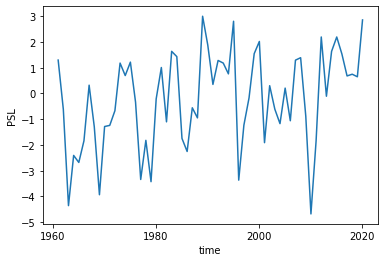

In [17]:
djf = stnao_obs.time.dt.month==1
stnao_obs.where(djf).dropna('time').plot()

### EOF-based NAO

In [18]:
# Function for selecting the North Atlantic domain
def getnatl(ds):
    datwest = ds.sel(lon=slice(360-90,359.9))
    dateast = ds.sel(lon=slice(0,40))
    datwest['lon'] = datwest.lon - 360.
    datout = xr.concat([datwest, dateast], dim='lon')
    datout = datout.sel(lat=slice(20,80))
    return datout

In [19]:
%%time
# SMYLE/DPLE
def calcNAO(dat,lonneg, latneg):
    dat = dat.stack(z=['M','Y'])
    pc = xr.DataArray(np.zeros([dat.z.size, dat.L.size]), dims=['z','L'],
                      coords=[dat.z, dat.L],name='pc')
    pattern = xr.DataArray(np.zeros([dat.L.size, dat.lat.size, dat.lon.size]),
                           dims=['L','lat','lon'], 
                           coords=[dat.L, dat.lat, dat.lon], name='pattern')
    for iseas in np.arange(dat.L.size):
        pct, eoft = eof.eofcalc_pcnorm(dat.isel(L=iseas), neofs=1, timeaxis='z', lonneg=lonneg, latneg=latneg)
        pc[:,iseas] = pct[:,0]
        pattern[iseas,:,:] = eoft[0,:,:]
    pc = pc.unstack(dim='z')
    return pc, pattern

smyle02_pc, smyle02_pattern = calcNAO(getnatl(smyle02_anom), -20, 75)
smyle05_pc, smyle05_pattern = calcNAO(getnatl(smyle05_anom), -20, 75)
smyle08_pc, smyle08_pattern = calcNAO(getnatl(smyle08_anom), -20, 75)
smyle11_pc, smyle11_pattern = calcNAO(getnatl(smyle11_anom), -20, 75)
dple11_pc, dple11_pattern = calcNAO(getnatl(dple11_anom), -20, 75)

CPU times: user 2min 10s, sys: 6.42 s, total: 2min 16s
Wall time: 2min 24s


In [20]:
%%time
# ERA5
def calcNAO(dat, lonneg, latneg):
    pc = xr.DataArray(np.zeros([dat.time.size]), dims=['time'], coords=[dat.time],name='pc')
    pattern = xr.DataArray(np.zeros([dat.lat.size, dat.lon.size]),
                           dims=['lat','lon'], 
                           coords=[dat.lat, dat.lon], name='pattern')
    pct, eoft = eof.eofcalc_pcnorm(dat, neofs=1, timeaxis='time', lonneg=lonneg, latneg=latneg)
    pc[:] = pct[:,0]
    pattern[:,:] = eoft[0,:,:]
    return pc, pattern

obs = era5_psl_seas
pclist=[]
patlist=[]
for mon in range(12):
    thismonth = obs.time.dt.month==(mon+1)
    tmp = obs.where(thismonth).dropna('time')
    tmp = tmp - tmp.sel(time=slice(str(climy0),str(climy1))).mean('time')
    pc,pat = calcNAO(getnatl(tmp), -20, 75)
    pclist.append(pc)
    patlist.append(pat)
pcnao_obs = xr.combine_nested(pclist,concat_dim=[None]).pc
patnao_obs = xr.concat(patlist,dim='month')

CPU times: user 2.62 s, sys: 994 ms, total: 3.62 s
Wall time: 3.73 s


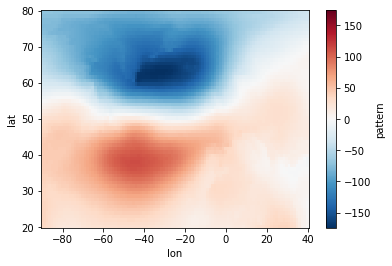

In [21]:
patnao_obs.isel(month=4).plot()

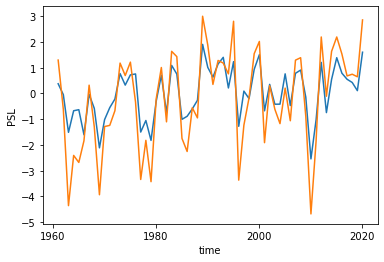

In [22]:
# Compare observed DJF NAO using two different methods:
djf = pcnao_obs.time.dt.month==1
pcnao_obs.where(djf).dropna('time').plot()
stnao_obs.where(djf).dropna('time').plot()

# Skill Analysis

In [23]:
%%time
smyle11_skill_st = stats.compute_skill_seasonal(stnao_smyle11_seas,smyle11_time,stnao_obs,str(climy0),str(climy1),1,7,resamp=0,detrend=False)
smyle02_skill_st = stats.compute_skill_seasonal(stnao_smyle02_seas,smyle02_time,stnao_obs,str(climy0),str(climy1),1,7,resamp=0,detrend=False)
smyle05_skill_st = stats.compute_skill_seasonal(stnao_smyle05_seas,smyle05_time,stnao_obs,str(climy0),str(climy1),1,7,resamp=0,detrend=False)
smyle08_skill_st = stats.compute_skill_seasonal(stnao_smyle08_seas,smyle08_time,stnao_obs,str(climy0),str(climy1),1,7,resamp=0,detrend=False)
dple11_skill_st = stats.compute_skill_seasonal(stnao_dple11_seas,dple11_time,stnao_obs,str(climy0),str(climy1),1,7,resamp=0,detrend=False)

CPU times: user 540 ms, sys: 1.98 ms, total: 542 ms
Wall time: 600 ms


In [24]:
%%time
smyle11_skill_pc = stats.compute_skill_seasonal(smyle11_pc,smyle11_time,pcnao_obs,str(climy0),str(climy1),1,7,resamp=0,detrend=False)
smyle02_skill_pc = stats.compute_skill_seasonal(smyle02_pc,smyle02_time,pcnao_obs,str(climy0),str(climy1),1,7,resamp=0,detrend=False)
smyle05_skill_pc = stats.compute_skill_seasonal(smyle05_pc,smyle05_time,pcnao_obs,str(climy0),str(climy1),1,7,resamp=0,detrend=False)
smyle08_skill_pc = stats.compute_skill_seasonal(smyle08_pc,smyle08_time,pcnao_obs,str(climy0),str(climy1),1,7,resamp=0,detrend=False)
dple11_skill_pc = stats.compute_skill_seasonal(dple11_pc,dple11_time,pcnao_obs,str(climy0),str(climy1),1,7,resamp=0,detrend=False)

CPU times: user 524 ms, sys: 1.08 ms, total: 525 ms
Wall time: 525 ms


### Compute resampled (20-member) DPLE Skill

In [25]:
import xskillscore as xs

In [26]:
%%time
iterations = 100
ens_size = 20
stnao_dple11_seas_resamp = xs.resample_iterations(stnao_dple11_seas.chunk(), iterations, 'M', dim_max=ens_size).persist()

CPU times: user 214 ms, sys: 14.5 ms, total: 229 ms
Wall time: 533 ms


In [28]:
%%time
dple11_skill_st_20mem = stats.compute_resampskill_seasonal(stnao_dple11_seas_resamp,dple11_time,stnao_obs,str(climy0),str(climy1),1,7,detrend=False,resamp=0,mean=False).load()

CPU times: user 42.2 s, sys: 349 ms, total: 42.6 s
Wall time: 45.2 s


In [29]:
# combine skill score xarrays for plotting
startmonth= xr.DataArray([11,2,5,8],name='startmonth',dims='startmonth')
smyle_skill_st = xr.concat([smyle11_skill_st,smyle02_skill_st,smyle05_skill_st,smyle08_skill_st],dim=startmonth)
smyle_skill_pc = xr.concat([smyle11_skill_pc,smyle02_skill_pc,smyle05_skill_pc,smyle08_skill_pc],dim=startmonth)
smyle_time = xr.concat([smyle11_time,smyle02_time,smyle05_time,smyle08_time],dim=startmonth)

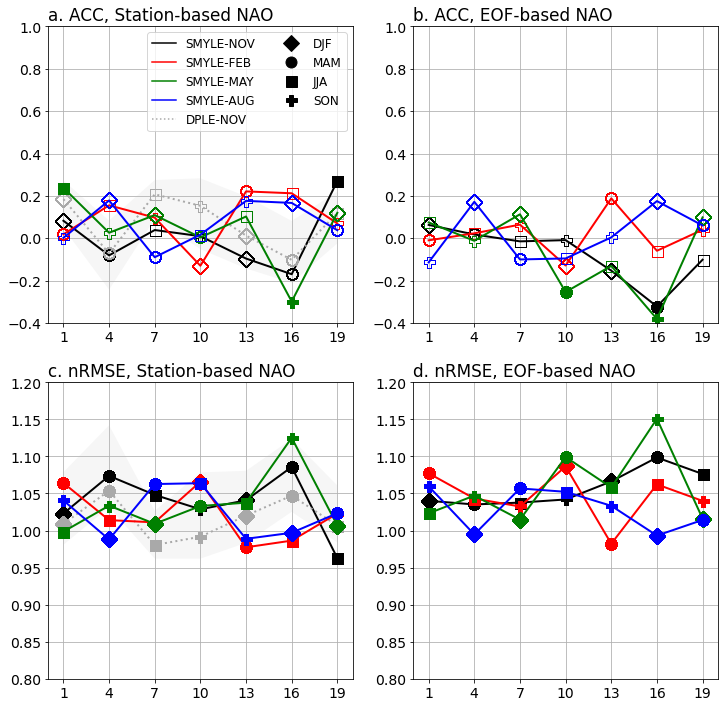

In [32]:
# plot skill scores
import matplotlib.lines as mlines
fig = plt.figure(figsize=(12,12))
plt.rcParams['font.size'] = '14'
leadmon = smyle_skill_st.L-2
seasdict = {1:'DJF',4:'MAM',7:'JJA',10:'SON'}
seasmon = [1,4,7,10]
markers = ['D','o','s','P']
colors = ['k','r','g','b']
dple_color = 'darkgrey'
hindcasts = ['NOV','FEB','MAY','AUG']
figlabs = [['a.','b.'],['c.','d.']]

def addlegend(ax):
    nov = mlines.Line2D([],[], color='k', label='SMYLE-NOV')
    feb = mlines.Line2D([],[], color='r', label='SMYLE-FEB')
    may = mlines.Line2D([],[], color='g', label='SMYLE-MAY')
    aug = mlines.Line2D([],[], color='b', label='SMYLE-AUG')
    dple = mlines.Line2D([],[], color=dple_color, label='DPLE-NOV', linestyle='dotted')
    djf = mlines.Line2D([],[],color='k', marker=markers[0], markersize=11, label='DJF', linestyle='None')
    mam = mlines.Line2D([],[],color='k', marker=markers[1], markersize=11, label='MAM', linestyle='None')
    jja = mlines.Line2D([],[],color='k', marker=markers[2], markersize=11, label='JJA', linestyle='None')
    son = mlines.Line2D([],[],color='k', marker=markers[3], markersize=11, label='SON', linestyle='None')
    ax.legend(handles=[nov, feb, may, aug, dple, djf, mam, jja, son], ncol=2, fontsize=12)

ncol = 2
nrow = 2

for i in range(ncol):
    ax = fig.add_subplot(nrow,ncol,i+1)
    if i==0: 
        ax.set_title(figlabs[0][i]+' ACC, Station-based NAO',loc='left')
        smyle_skill = smyle_skill_st
        dple11_skill = dple11_skill_st
    else:
        ax.set_title(figlabs[0][i]+' ACC, EOF-based NAO',loc='left')
        smyle_skill = smyle_skill_pc
        dple11_skill = dple11_skill_pc
    for j in range(4):
        ax.plot(leadmon,smyle_skill.isel(startmonth=j).corr,color=colors[j],linewidth=2,label='SMYLE-'+hindcasts[j])
        for k,l in zip(seasmon,markers):
            tmp = smyle_skill.isel(startmonth=j)
            tmptime = smyle_time.isel(startmonth=j)
            ax.plot(leadmon,tmp.corr.where(tmptime.dt.month==k),color=colors[j],marker=l,markersize=11,fillstyle='none')
            ax.plot(leadmon,tmp.corr.where(tmptime.dt.month==k).where(tmp.pval<0.1),color=colors[j],marker=l,markersize=11)
        if (i==0 and j==0):
            ax.plot(leadmon,dple11_skill.corr,color=dple_color,linewidth=2,label='DPLE-NOV',linestyle='dotted')
            for k,l in zip(seasmon,markers):
                tmp = dple11_skill
                tmptime = dple11_time
                ax.plot(leadmon,tmp.corr.where(tmptime.dt.month==k),color=dple_color,marker=l,markersize=11,fillstyle='none')
                ax.plot(leadmon,tmp.corr.where(tmptime.dt.month==k).where(tmp.pval<0.1),color=dple_color,marker=l,markersize=11)
            ymin = dple11_skill_st_20mem.corr.quantile(0.05,dim='iteration'); ymax = dple11_skill_st_20mem.corr.quantile(0.95,dim='iteration')
            ax.fill_between(leadmon,ymin,ymax,fc='lightgrey',alpha=0.2)
            
    ax.set_xticks(leadmon)
    ax.grid(True)
    ax.set_xlim([0,20])
    ax.set_ylim([-0.4,1])
    if i==0: addlegend(ax)
    
    ax = fig.add_subplot(nrow,ncol,i+3)
    if i==0: 
        ax.set_title(figlabs[1][i]+' nRMSE, Station-based NAO',loc='left')
        smyle_skill = smyle_skill_st
        dple11_skill = dple11_skill_st
    else:
        ax.set_title(figlabs[1][i]+' nRMSE, EOF-based NAO',loc='left')
        smyle_skill = smyle_skill_pc
        dple11_skill = dple11_skill_pc
    for j in range(4):
        ax.plot(leadmon,smyle_skill.isel(startmonth=j).rmse,color=colors[j],linewidth=2,label='SMYLE-'+hindcasts[j])
        for k,l in zip(seasmon,markers):
            tmp = smyle_skill.isel(startmonth=j)
            tmptime = smyle_time.isel(startmonth=j)
            ax.plot(leadmon,tmp.rmse.where(tmptime.dt.month==k),color=colors[j],marker=l,markersize=11)
        if (i==0 and j==0):
            ax.plot(leadmon,dple11_skill.rmse,color=dple_color,linewidth=2,label='DPLE-NOV',linestyle='dotted')
            for k,l in zip(seasmon,markers):
                tmp = dple11_skill
                tmptime = dple11_time
                ax.plot(leadmon,tmp.rmse.where(tmptime.dt.month==k),color=dple_color,marker=l,markersize=11)
            ymin = dple11_skill_st_20mem.rmse.quantile(0.05,dim='iteration'); ymax = dple11_skill_st_20mem.rmse.quantile(0.95,dim='iteration')
            ax.fill_between(leadmon,ymin,ymax,fc='lightgrey',alpha=0.2)
            
    ax.set_xticks(leadmon)
    ax.grid(True)
    ax.set_xlim([0,20])
    ax.set_ylim([0.8,1.2])
        
    
plt.savefig('f07.png')